In [514]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
import matplotlib.colors as mcolors
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS, CSS4_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [515]:
#just want to initialize all the data here
class Data_Set:

    def ready_frames(self, path):
        files = sorted(glob.glob(path + "/*"))
        print(files)
        opened = [fits.open(file) for file in files]
        self.image_data = [file[1].data for file in opened]
        self.headers = [frame[1].header for frame in opened] #keep all headers
        self.wcs = WCS(self.headers[0]) #wcs should be the same for each set
        self.obs_filter = self.headers[0]['FILTER'][0]
        self.set_length = len(self.image_data)
        self.readout_noise = self.headers[0]['RDNOISE']

    def align_frames(self, frames):
        try:
            aligned_frames = [aa.register(frame, frames[0])[0] for frame in frames[0:]]
            print("Frames aligned successfully.")
        except:
            aligned_frames = self.image_data
            raise UserWarning("AstroAlign could not align the image data")
        self.aligned_images = aligned_frames

    def combine(self, frames):
        try:
            self.template = np.median(frames, axis = 0)
        except:
            raise UserWarning("Please run self.align_frames() before combining")

    def extract_sources(self, template):
        bkg_phot = sep.Background(template) #background subtract for source extraction.
        self.sources = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False)


    def __init__(self, path, set_number):
        print(path)
        self.path = path
        self.obs_night = set_number


In [516]:
class Source:

    def query_source(self):
        search = SDSS.query_crossid(self.ra_dec, fields = ['ra', 'dec', f'psfMag_{Sets[0].obs_filter}', f'psfMagErr_{Sets[0].obs_filter}'], radius = 15 * u.arcsec, region = False)
        if search:
            self.is_reference = True
            self.reference_mag = search[f'psfMag_{Sets[0].obs_filter}']
            self.reference_mag_err = search[f'psfMagErr_{Sets[0].obs_filter}']

    def border_check(self, night):
        source_xy = SkyCoord.to_pixel(self.ra_dec, wcs = night.wcs)
        if (night.headers[0]['NAXIS1'] - source_xy[0]) < 0 or source_xy[0] < 0 or (night.headers[0]['NAXIS2'] - source_xy[1]) < 0 or source_xy[1] < 0:
            self.bad_source_flag = True


    def aperture_photometry(self, image, night):

        coords = SkyCoord.to_pixel(self.ra_dec, wcs = night.wcs) #gets pixel values of source from RA DEC
        pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions
        radius_i = self.radius
        radius_o_0 = radius_i + 5 #inner annulus radius
        radius_o_1 = radius_o_0 + 5 #outer annulus radius

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(image) #gets data of source

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
        background_mean = ApertureStats(image, background_annulus).mean

        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix) #total flux

        readout_sum_square = np.sum(source_circle*np.float64(night.readout_noise**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

        delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(image, background_annulus)['aperture_sum'][0]))**(1/2) #this is the stuff for SNR

        if source_flux_total < 0:
            self.bad_source_flag = True

        else:
            instrumental_mag = -2.5*np.log10(source_flux_total)
            instrumental_mag_error = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
            return  instrumental_mag, instrumental_mag_error

    def calibrate_source(self, calibration):
        for i, mag in enumerate(self.instrumental_mags):
            self.calibrated_mags.append(np.float64(mag*calibration[i][0] + calibration[i][1]))

    def get_info(self):
        return(self.ra_dec, f"Source Radius: {self.radius}", f"Source Id: {self.source_id}", f"Is Reference Star: {self.is_reference}" , f"Is Bad Source: {self.bad_source_flag}" )

    def __init__(self, source, Id):
        self.ra_dec = pixel_to_skycoord(source['x'], source['y'], Sets[0].wcs).transform_to('icrs') #gives wcs transformation for pixel coordinates
        self.radius = (source['xmax'] - source['xmin'])/2
        self.source_id = Id
        self.is_reference = None #these fields will populate after running their respective functions
        self.bad_source_flag = None
        self.instrumental_mags = []
        self.instrumental_mag_errs = []
        self.calibrated_mags = []


In [517]:

files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #filepath for multi, this is a directory containing directories.
Sets = [Data_Set(directory, run_number) for run_number, directory in enumerate(files)] #initialize the sets
for i, night in enumerate(Sets):
    night.ready_frames(night.path) #opens files, pulls image and header data for use
    night.align_frames(night.image_data) #tries to align frames
    night.combine(night.aligned_images) #makes median template
    night.extract_sources(night.template) #extracts sources




/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r
['/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r/ogg0m406-kb27-20230525-0124-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r/ogg0m406-kb27-20230525-0125-e91.fits.fz', '/Users/lucaangeleri/Docu

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Frames aligned successfully.
['/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0091-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0092-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0093-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0094-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0095-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0096-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0097-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r/tfn0m410-kb24-20230530-0098-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Frames aligned successfully.
['/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0175-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0176-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0177-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0178-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0179-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0180-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0181-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r/tfn0m410-kb24-20230610-0182-e91.fits.fz', '/Users/lucaangeleri/Documents/LCO

In [518]:
#source querying
sources = [Source(source, count) for count, source in enumerate(Sets[0].sources)] #initializes each source
for s in sources:
    s.query_source()

In [519]:
print(len(sources))

81


In [520]:

#aperture photometry:
for night in Sets:
    print(night.obs_night, len(night.image_data))
    for image in night.aligned_images:
        for i, source in enumerate(sources):
            source.border_check(night)
            if source.bad_source_flag != True:
                try:
                    inst_mag, inst_mag_err  = source.aperture_photometry(image, night)
                    source.instrumental_mags.append(inst_mag)
                    source.instrumental_mag_errs.append(inst_mag_err)
                except:
                    print(f"Negative Flux Source Encountered at RA_DEC:{source.ra_dec}")



0 25
1 25
2 25
3 25
4 25
5 25
6 25
7 25
8 25
9 25


In [521]:
#calibration:
mag_thresh = 15 #make a click option
calibration_parameters = []
night_array =[]


for night in Sets:
    for i, image in enumerate(night.aligned_images):
        instrumental_mags = [source.instrumental_mags[i] for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]
        sky_mags = [source.reference_mag for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]
        p = np.polyfit(instrumental_mags, sky_mags, deg = 1) #make this a function somewhere later
        calibration_parameters.append(p)
        night_array.append(night.obs_night)
"""

for night in Sets:
    index_low = len(night.image_data)*night.obs_night
    index_high = len(night.image_data)+len(night.image_data)*night.obs_night
    instrumental_mags = [np.mean(source.instrumental_mags[index_low:index_high]) for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]
    sky_mags = [source.reference_mag for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]
    p = np.polyfit(instrumental_mags, sky_mags, deg = 1)
    calibration_parameters.append(p)
    [night_array.append(night.obs_night) for image in night.image_data]

calibration_final = np.array(calibration_parameters)[np.array(night_array)]
"""

'\n\nfor night in Sets:\n    index_low = len(night.image_data)*night.obs_night\n    index_high = len(night.image_data)+len(night.image_data)*night.obs_night\n    instrumental_mags = [np.mean(source.instrumental_mags[index_low:index_high]) for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]\n    sky_mags = [source.reference_mag for source in sources if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag != True]\n    p = np.polyfit(instrumental_mags, sky_mags, deg = 1)\n    calibration_parameters.append(p)\n    [night_array.append(night.obs_night) for image in night.image_data]\n\ncalibration_final = np.array(calibration_parameters)[np.array(night_array)]\n'

In [522]:

for source in sources:
    source.calibrate_source(calibration_parameters)

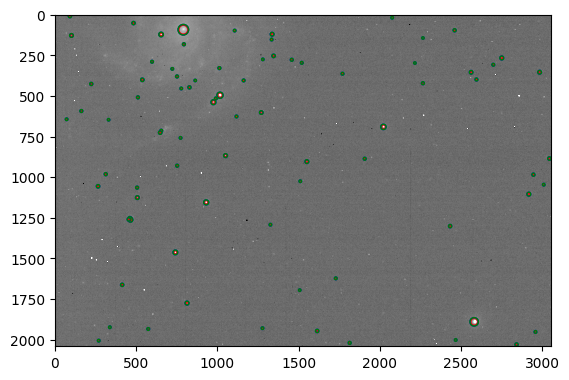

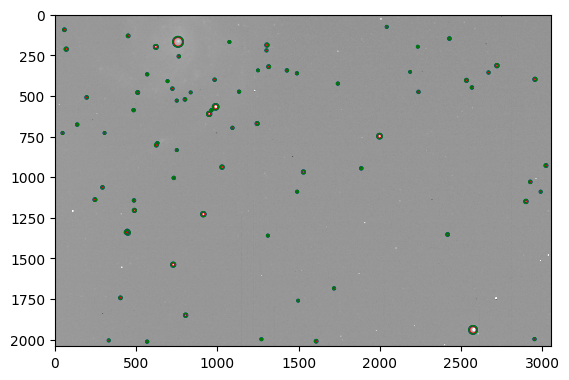

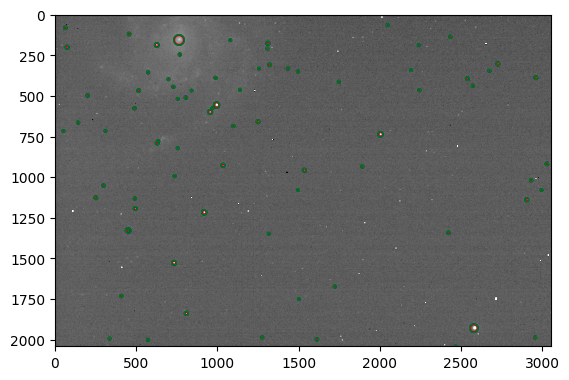

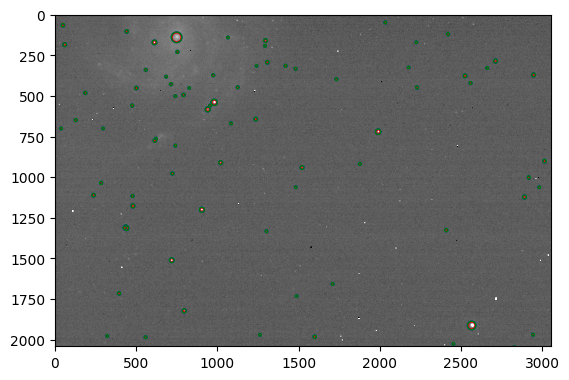

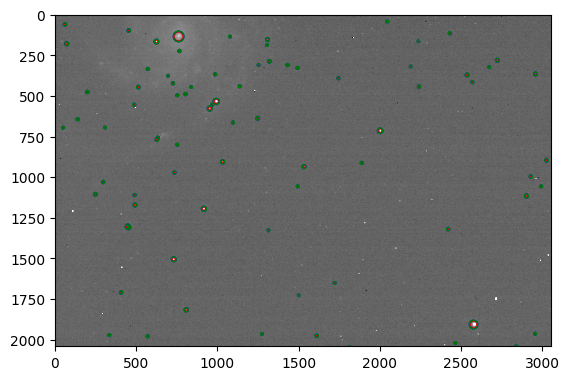

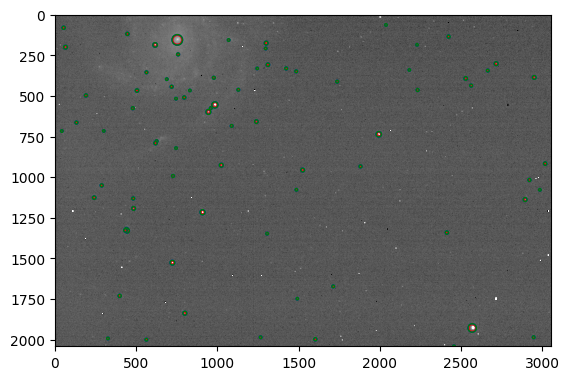

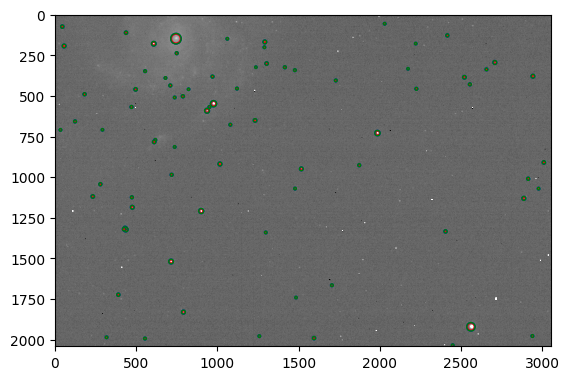

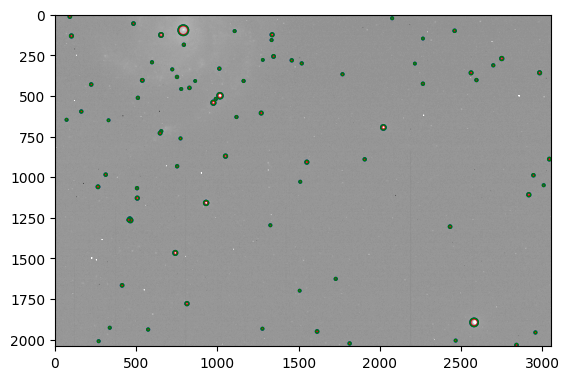

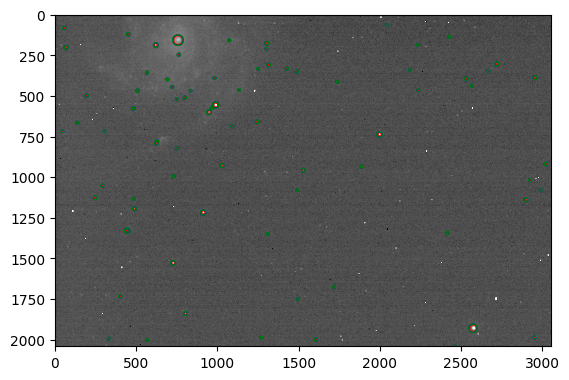

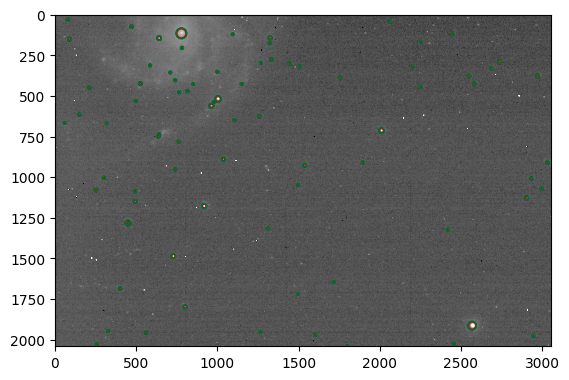

In [523]:

for i, night in enumerate(Sets):
    for source in sources:
        x, y = SkyCoord.to_pixel(source.ra_dec, wcs= night.wcs)
        circle0 = plt.Circle((x, y), source.radius, color = 'r', fill = False)
        circle1 = plt.Circle((x, y), source.radius + 5, color = 'b', fill = False)
        circle2 = plt.Circle((x,y), source.radius +5, color = 'g',fill = False)
        ax = plt.gca()
        ax.add_patch(circle0)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    plt.imshow(night.template, cmap= 'gray', norm= LogNorm(vmin = 1, vmax = 200))
    plt.show()


250 250
250


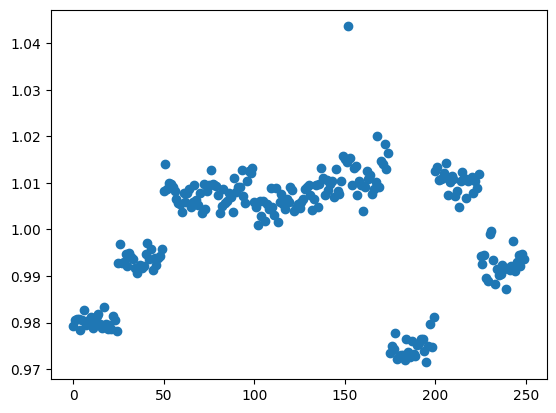

In [524]:
l = np.arange(0, len(calibration_parameters))
print(len(l), len(calibration_parameters))
curves = [source.calibrated_mags for source in sources if source.bad_source_flag != True]
med_curve = np.median(curves, axis = 0)/np.median(curves)
print(len(med_curve))
plt.scatter(l, med_curve)
plt.show()


In [525]:
color_arr = np.array(sorted(CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))))
print(color_arr[10::5][np.array(night_array)])



['gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro'
 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro'
 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro'
 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro' 'gainsboro'
 'gainsboro' 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral'
 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral'
 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral'
 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral'
 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral' 'lightcoral'
 'lightcoral' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred'
 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred'
 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darkred'
 'darkred' 'darkred' 'darkred' 'darkred' 'darkred' 'darksalmon'
 'darksalmon' 'darksalmon' 'darksalmon' 'darksalmon' 'darksalmon'
 'darksalmon' 'darksalmon' 'darks

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, 'Source Radius: 5.0', 'Source Id: 0', 'Is Reference Star: None', 'Is Bad Source: None')


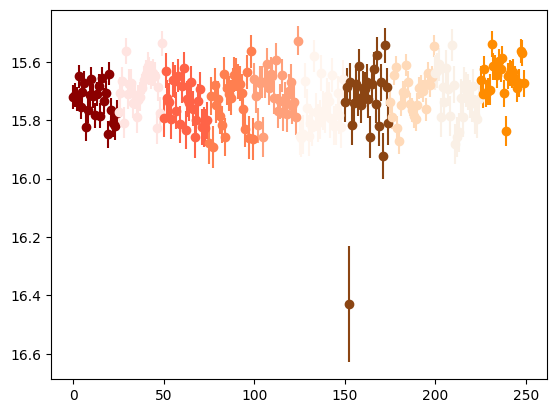

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.77550571, 54.14508597)>, 'Source Radius: 3.0', 'Source Id: 1', 'Is Reference Star: None', 'Is Bad Source: None')


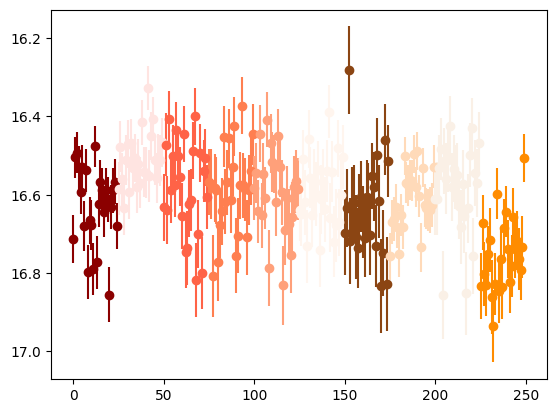

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.79248564, 54.39747745)>, 'Source Radius: 5.0', 'Source Id: 2', 'Is Reference Star: None', 'Is Bad Source: None')


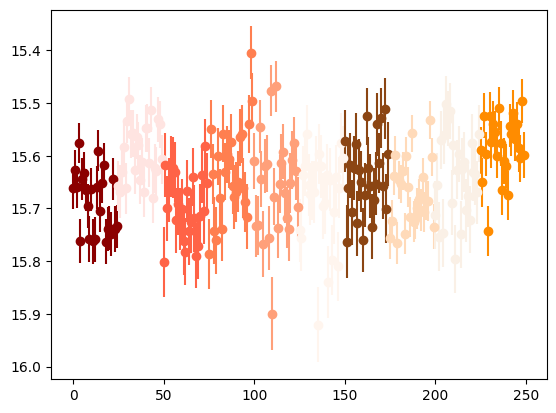

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80186801, 54.29859178)>, 'Source Radius: 3.0', 'Source Id: 3', 'Is Reference Star: None', 'Is Bad Source: None')


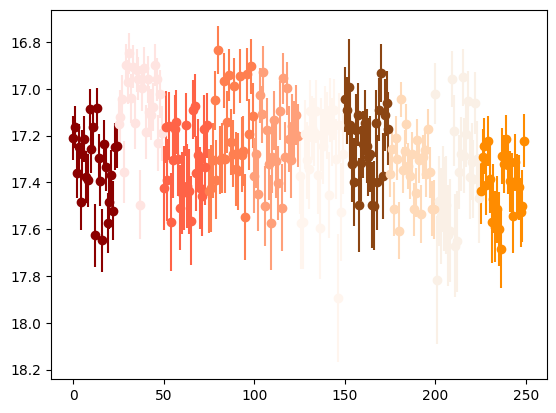

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.79447654, 54.0838712)>, 'Source Radius: 4.5', 'Source Id: 4', 'Is Reference Star: None', 'Is Bad Source: None')


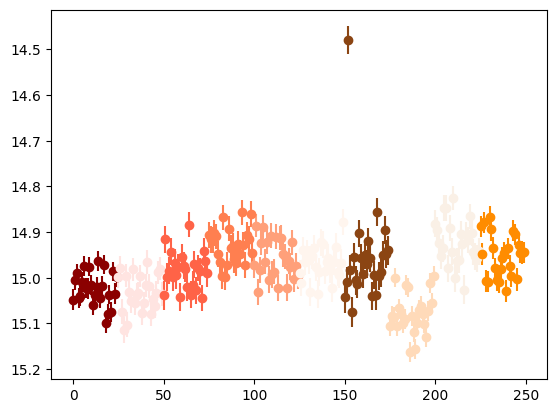

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80206959, 54.34873014)>, 'Source Radius: 27.5', 'Source Id: 5', 'Is Reference Star: None', 'Is Bad Source: None')


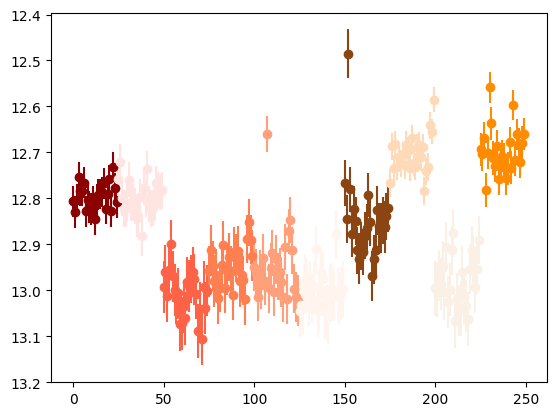

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80676757, 54.26196473)>, 'Source Radius: 6.5', 'Source Id: 6', 'Is Reference Star: None', 'Is Bad Source: None')


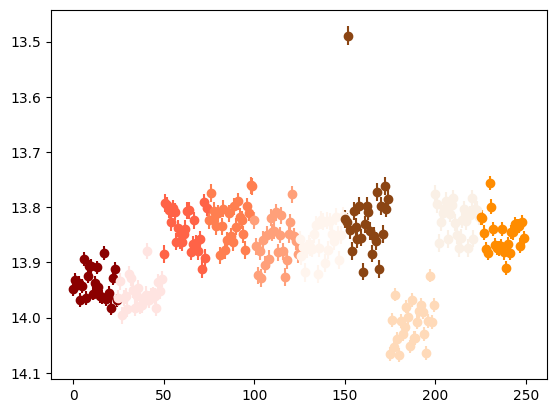

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.81073532, 54.37035913)>, 'Source Radius: 9.0', 'Source Id: 7', 'Is Reference Star: None', 'Is Bad Source: None')


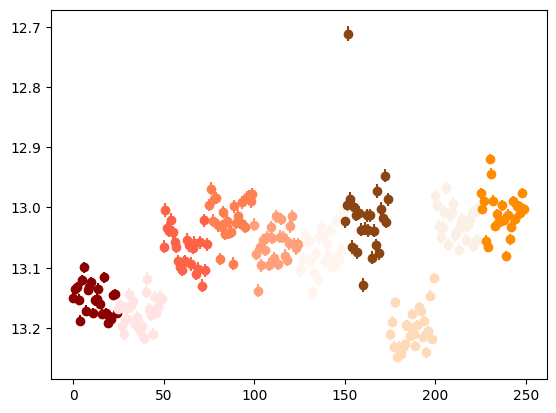

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8152421, 54.45781723)>, 'Source Radius: 6.5', 'Source Id: 8', 'Is Reference Star: None', 'Is Bad Source: None')


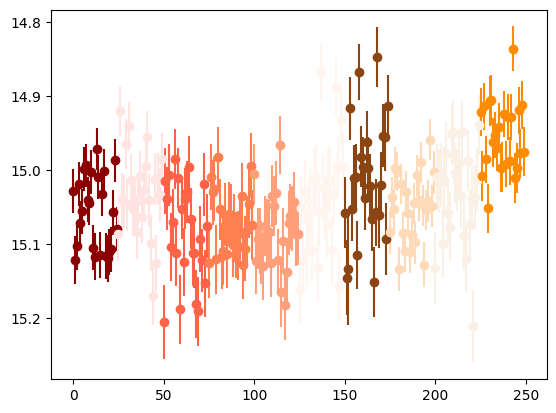

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80834476, 54.11467639)>, 'Source Radius: 2.5', 'Source Id: 9', 'Is Reference Star: None', 'Is Bad Source: None')


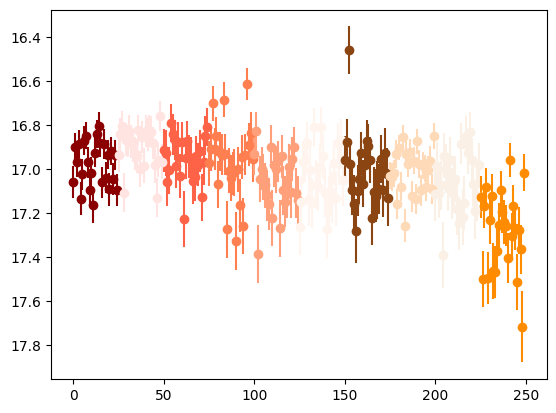

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.81572421, 54.26237173)>, 'Source Radius: 3.0', 'Source Id: 10', 'Is Reference Star: None', 'Is Bad Source: None')


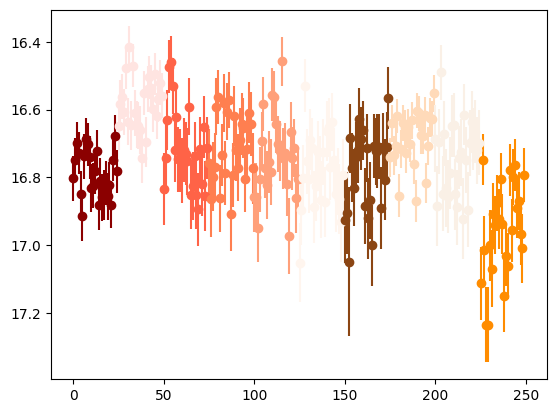

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.82637993, 54.34790299)>, 'Source Radius: 4.0', 'Source Id: 11', 'Is Reference Star: None', 'Is Bad Source: None')


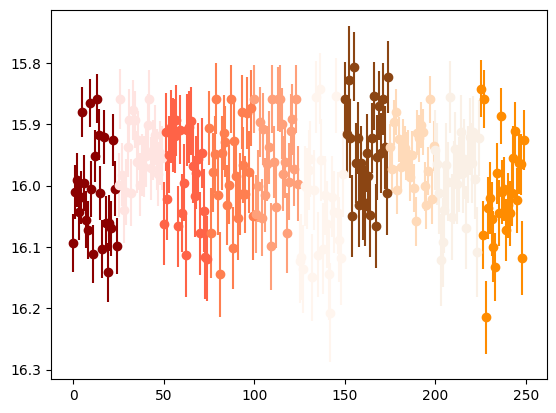

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.84294319, 54.26012276)>, 'Source Radius: 5.5', 'Source Id: 12', 'Is Reference Star: None', 'Is Bad Source: None')


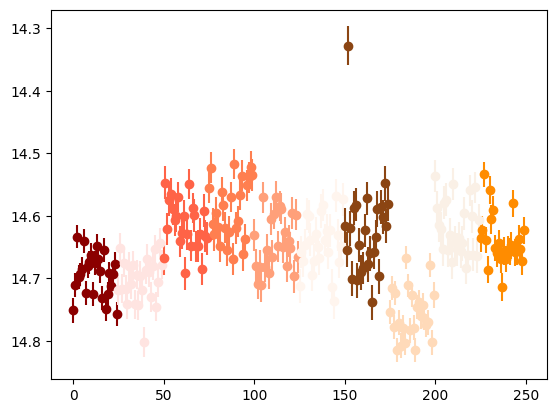

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.83908433, 54.0373817)>, 'Source Radius: 7.0', 'Source Id: 13', 'Is Reference Star: True', 'Is Bad Source: None')


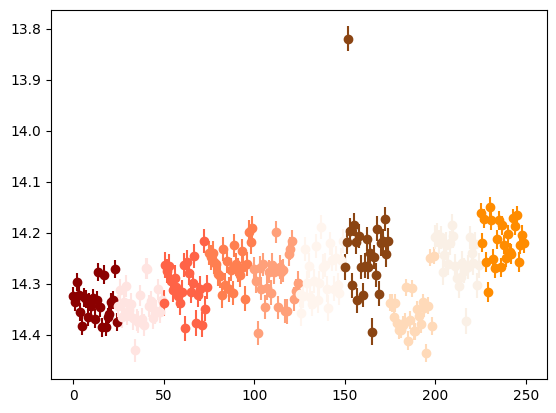

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8491348, 54.27057194)>, 'Source Radius: 2.5', 'Source Id: 14', 'Is Reference Star: None', 'Is Bad Source: None')


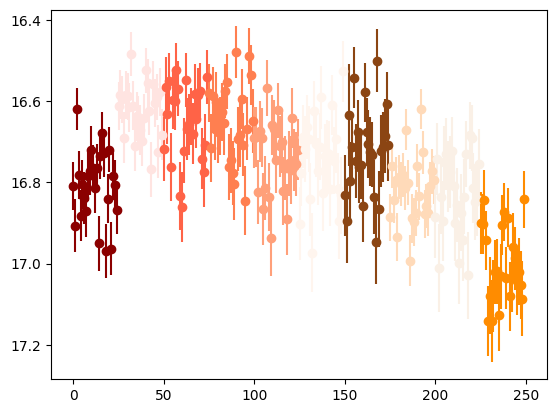

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.84889875, 54.24229868)>, 'Source Radius: 4.0', 'Source Id: 15', 'Is Reference Star: None', 'Is Bad Source: None')


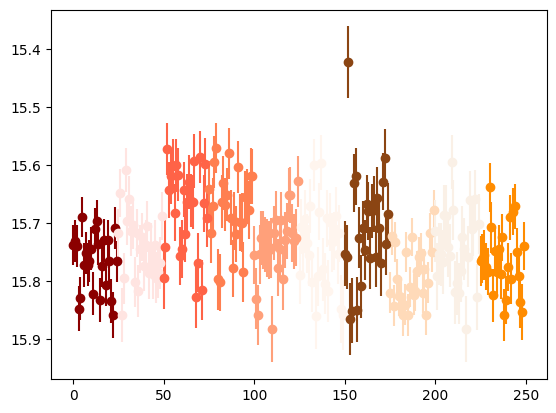

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85672758, 54.37867585)>, 'Source Radius: 3.5', 'Source Id: 16', 'Is Reference Star: None', 'Is Bad Source: None')


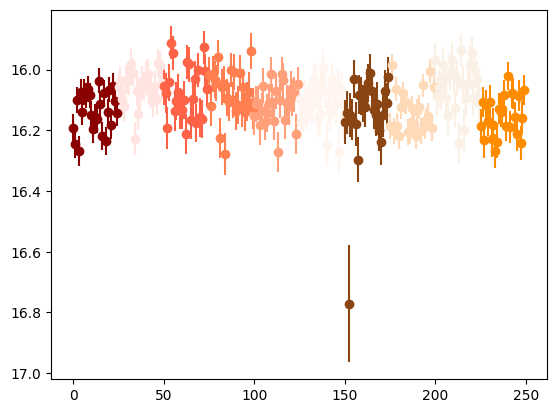

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85366314, 54.23249378)>, 'Source Radius: 3.5', 'Source Id: 17', 'Is Reference Star: None', 'Is Bad Source: None')


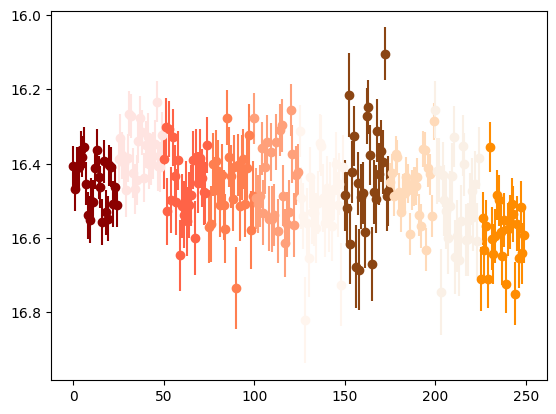

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85030384, 54.12207102)>, 'Source Radius: 2.5', 'Source Id: 18', 'Is Reference Star: True', 'Is Bad Source: None')


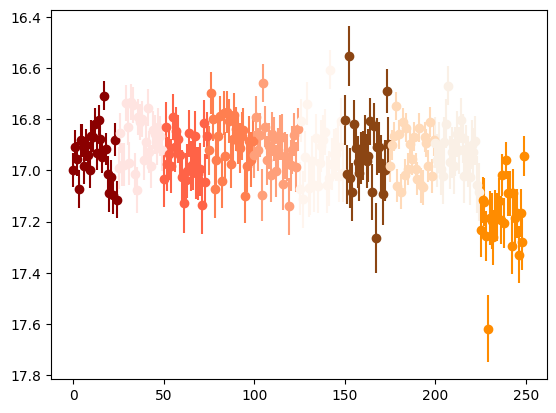

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85063554, 54.04551099)>, 'Source Radius: 3.5', 'Source Id: 19', 'Is Reference Star: True', 'Is Bad Source: None')


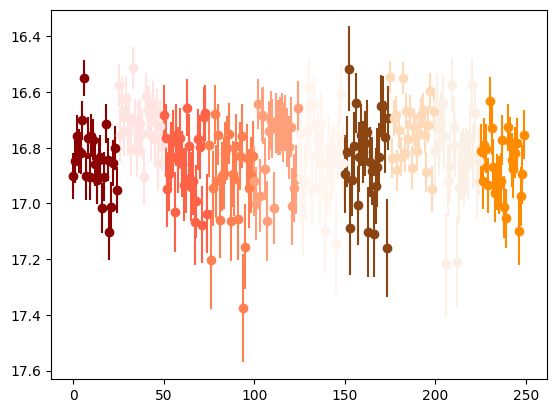

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86518663, 54.31283836)>, 'Source Radius: 4.0', 'Source Id: 20', 'Is Reference Star: None', 'Is Bad Source: None')


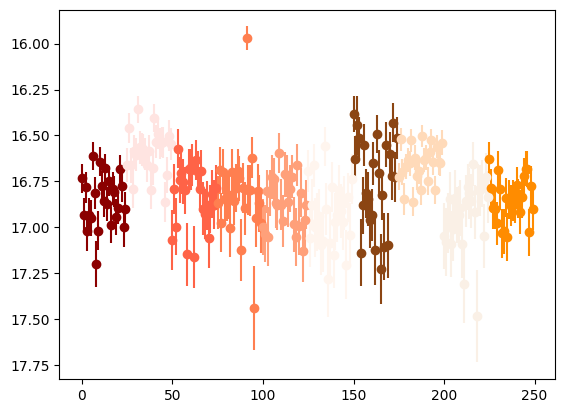

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86800042, 54.35876675)>, 'Source Radius: 3.0', 'Source Id: 21', 'Is Reference Star: None', 'Is Bad Source: None')


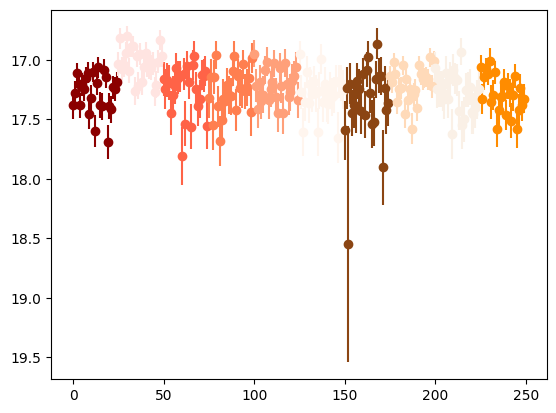

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86386421, 54.06701257)>, 'Source Radius: 6.0', 'Source Id: 22', 'Is Reference Star: True', 'Is Bad Source: None')


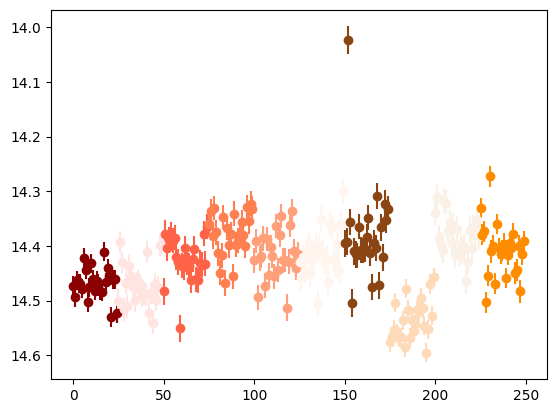

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8615306, 54.00013879)>, 'Source Radius: 6.5', 'Source Id: 23', 'Is Reference Star: True', 'Is Bad Source: None')


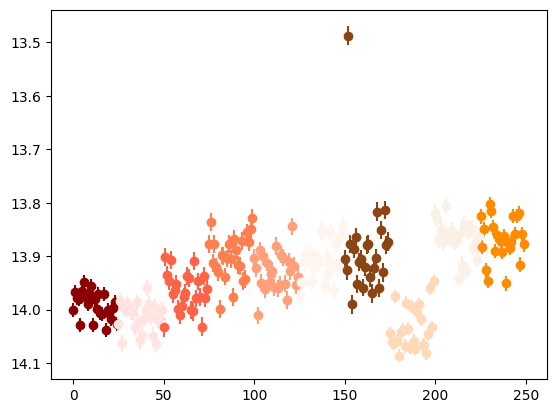

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.87048358, 54.19250825)>, 'Source Radius: 3.5', 'Source Id: 24', 'Is Reference Star: None', 'Is Bad Source: None')


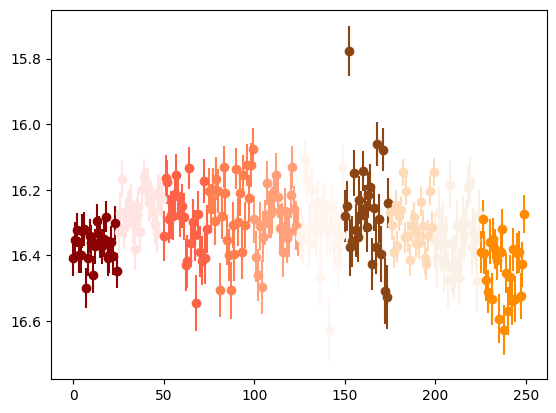

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8805303, 54.35398963)>, 'Source Radius: 4.0', 'Source Id: 25', 'Is Reference Star: None', 'Is Bad Source: None')


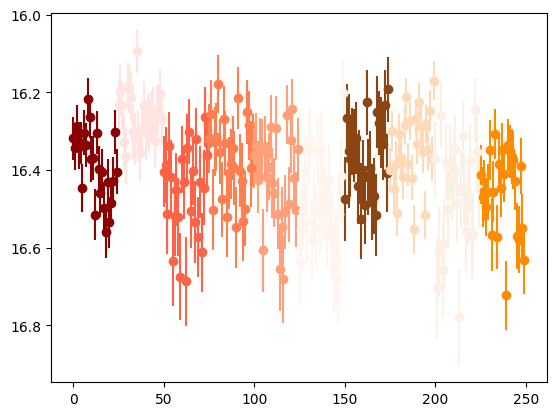

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.87569614, 54.06163606)>, 'Source Radius: 4.0', 'Source Id: 26', 'Is Reference Star: True', 'Is Bad Source: None')


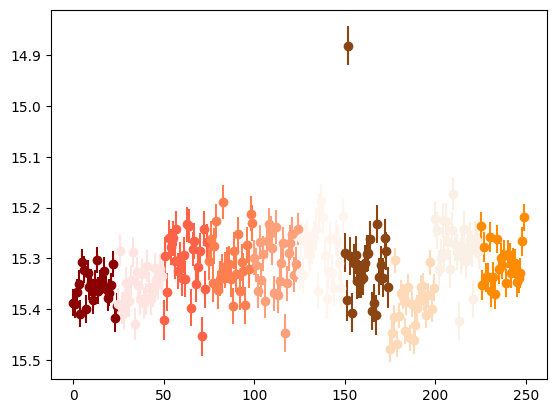

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88734587, 54.38781215)>, 'Source Radius: 5.5', 'Source Id: 27', 'Is Reference Star: None', 'Is Bad Source: None')


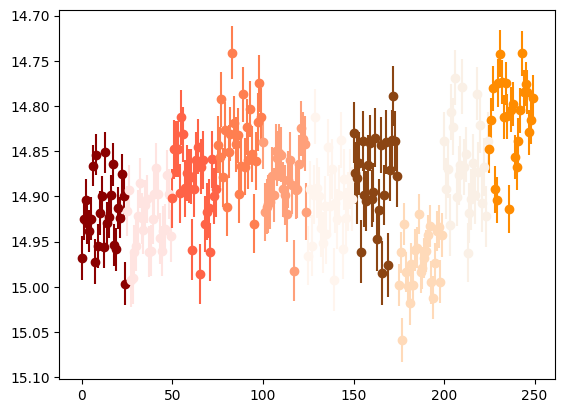

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88665759, 54.33614578)>, 'Source Radius: 2.5', 'Source Id: 28', 'Is Reference Star: None', 'Is Bad Source: None')


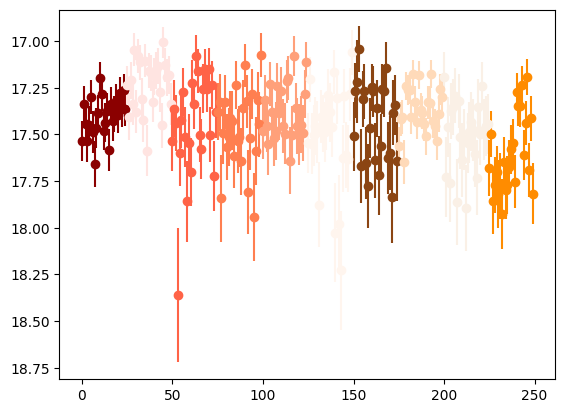

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88500977, 54.28890995)>, 'Source Radius: 3.5', 'Source Id: 29', 'Is Reference Star: None', 'Is Bad Source: None')


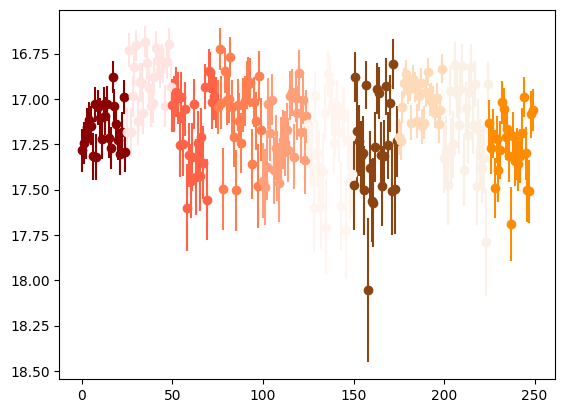

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88362985, 54.1138174)>, 'Source Radius: 4.0', 'Source Id: 30', 'Is Reference Star: True', 'Is Bad Source: None')


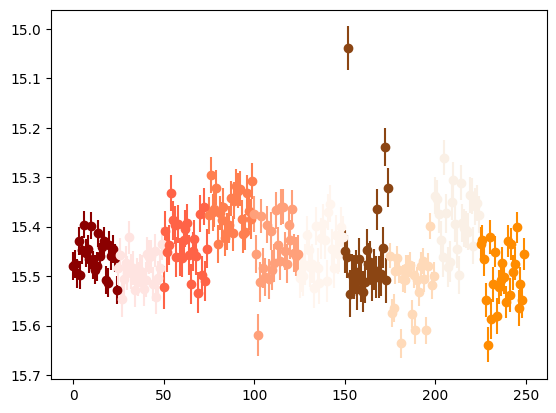

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.89603392, 54.43759338)>, 'Source Radius: 4.5', 'Source Id: 31', 'Is Reference Star: None', 'Is Bad Source: None')


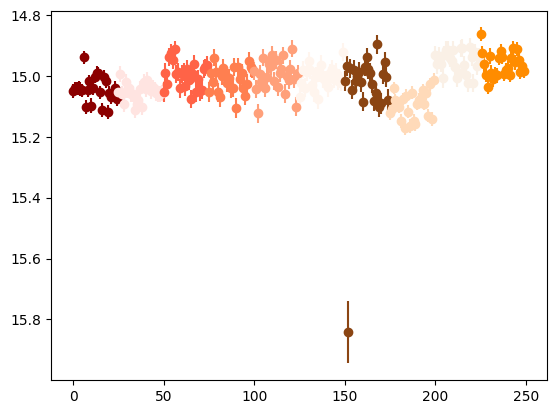

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.89840483, 54.3416589)>, 'Source Radius: 4.5', 'Source Id: 32', 'Is Reference Star: None', 'Is Bad Source: None')


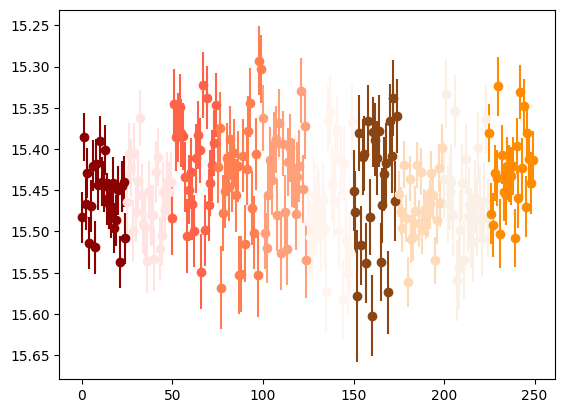

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.90052695, 54.34964825)>, 'Source Radius: 3.0', 'Source Id: 33', 'Is Reference Star: None', 'Is Bad Source: None')


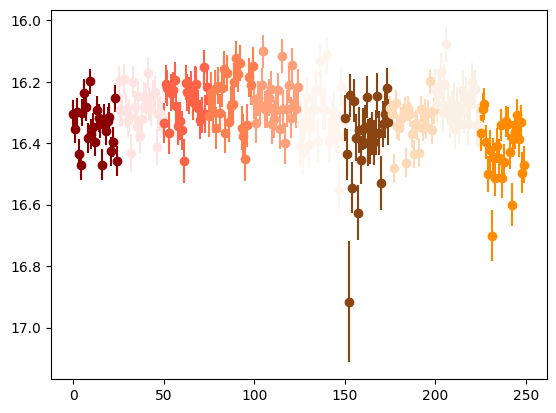

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91055426, 54.31169678)>, 'Source Radius: 14.0', 'Source Id: 34', 'Is Reference Star: None', 'Is Bad Source: None')


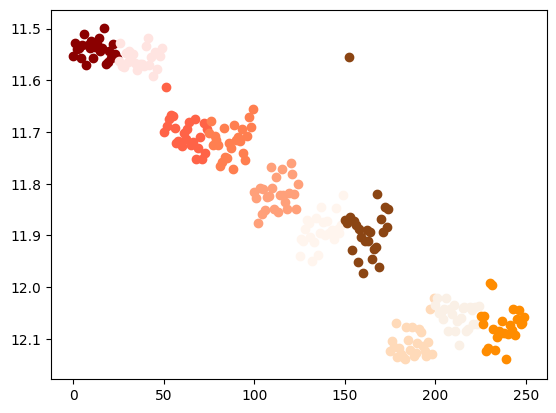

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91689781, 54.39173506)>, 'Source Radius: 4.0', 'Source Id: 35', 'Is Reference Star: None', 'Is Bad Source: None')


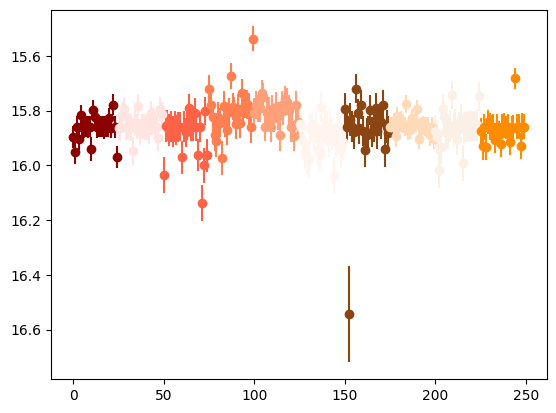

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91605555, 54.31568738)>, 'Source Radius: 3.5', 'Source Id: 36', 'Is Reference Star: None', 'Is Bad Source: None')


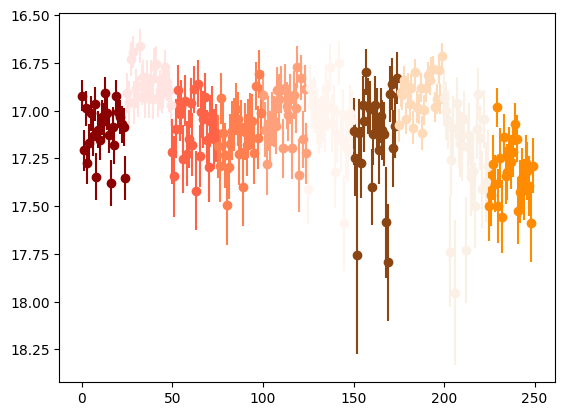

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.92241703, 54.31797144)>, 'Source Radius: 10.0', 'Source Id: 37', 'Is Reference Star: None', 'Is Bad Source: None')


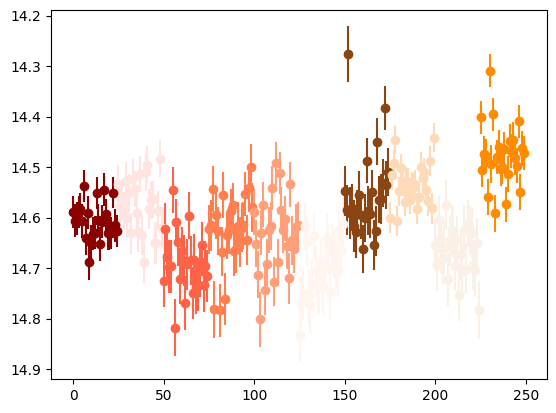

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.9417537, 54.44672344)>, 'Source Radius: 4.0', 'Source Id: 38', 'Is Reference Star: None', 'Is Bad Source: None')


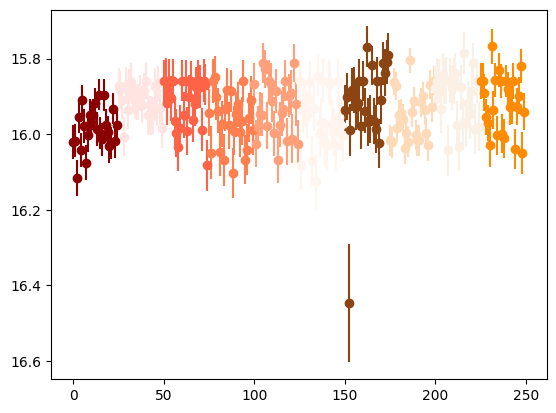

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.93805894, 54.27106037)>, 'Source Radius: 6.0', 'Source Id: 39', 'Is Reference Star: None', 'Is Bad Source: None')


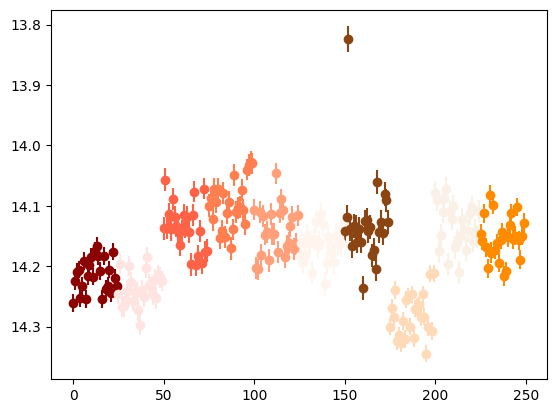

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.94550841, 54.29515842)>, 'Source Radius: 3.5', 'Source Id: 40', 'Is Reference Star: None', 'Is Bad Source: None')


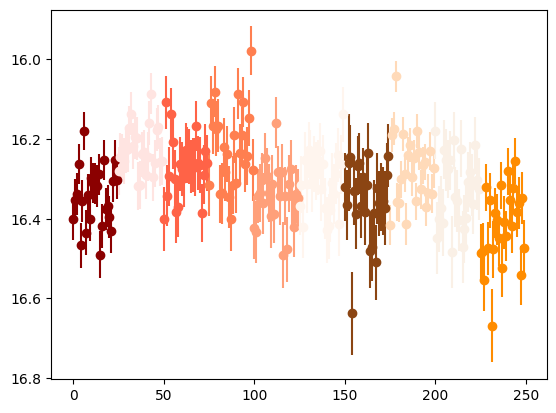

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95617089, 54.46091011)>, 'Source Radius: 3.0', 'Source Id: 41', 'Is Reference Star: True', 'Is Bad Source: None')


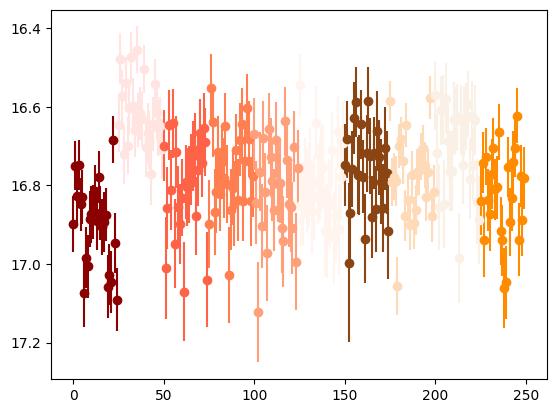

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95549419, 54.41993155)>, 'Source Radius: 2.5', 'Source Id: 42', 'Is Reference Star: None', 'Is Bad Source: None')


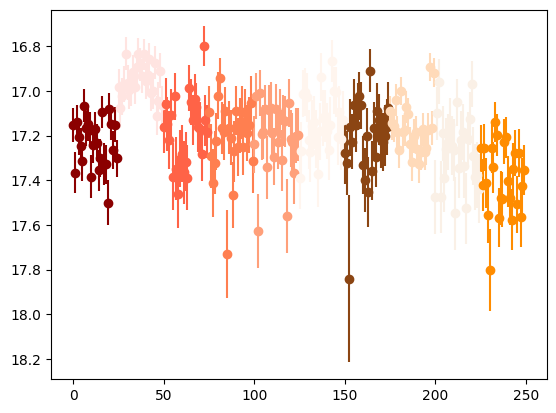

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95776278, 54.15153029)>, 'Source Radius: 11.5', 'Source Id: 43', 'Is Reference Star: True', 'Is Bad Source: None')


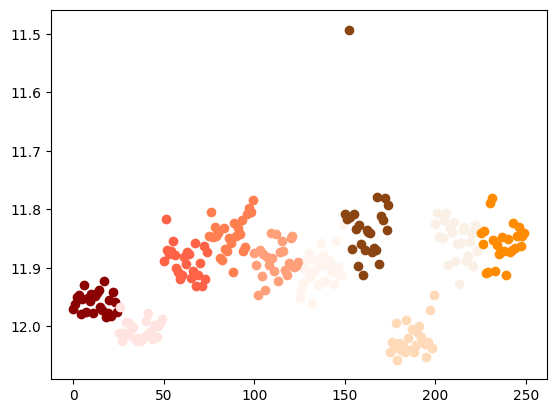

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.97193498, 54.36827617)>, 'Source Radius: 3.5', 'Source Id: 44', 'Is Reference Star: None', 'Is Bad Source: None')


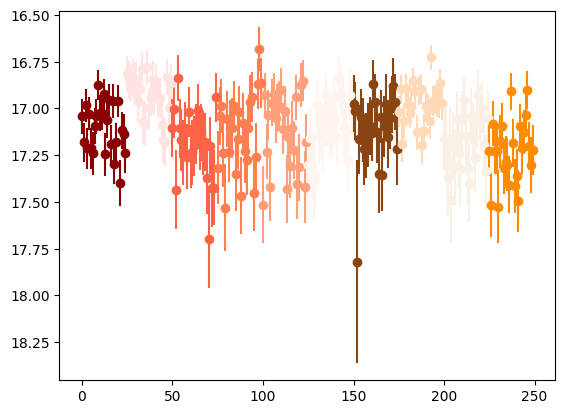

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.97523909, 54.36934526)>, 'Source Radius: 5.5', 'Source Id: 45', 'Is Reference Star: None', 'Is Bad Source: None')


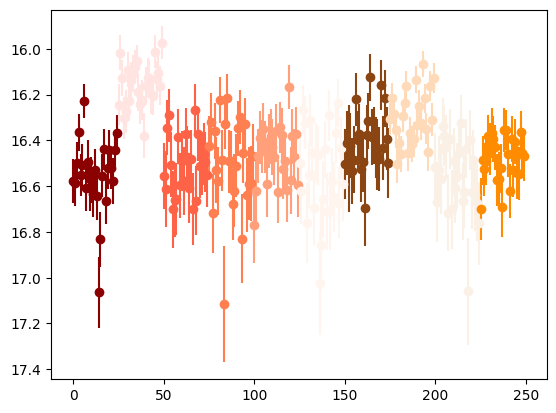

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.98336712, 54.34931789)>, 'Source Radius: 3.0', 'Source Id: 46', 'Is Reference Star: None', 'Is Bad Source: None')


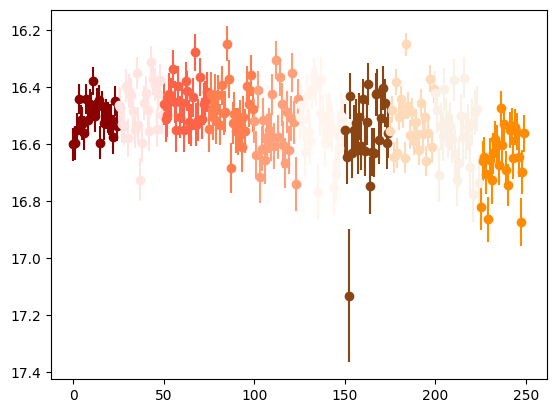

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01134848, 54.30502921)>, 'Source Radius: 7.0', 'Source Id: 47', 'Is Reference Star: None', 'Is Bad Source: None')


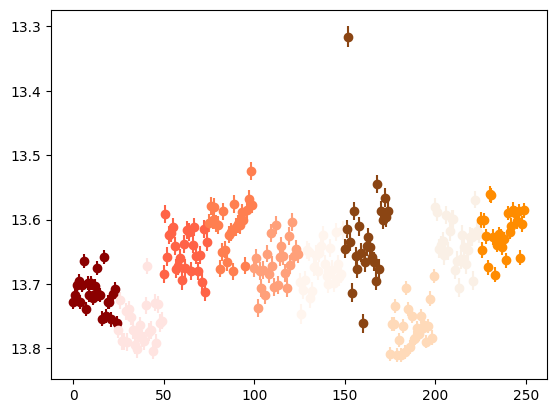

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01156344, 54.16910002)>, 'Source Radius: 4.0', 'Source Id: 48', 'Is Reference Star: True', 'Is Bad Source: None')


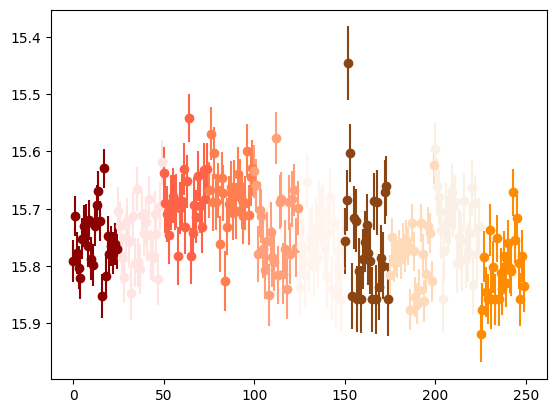

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.00453763, 53.98887093)>, 'Source Radius: 5.5', 'Source Id: 49', 'Is Reference Star: True', 'Is Bad Source: None')


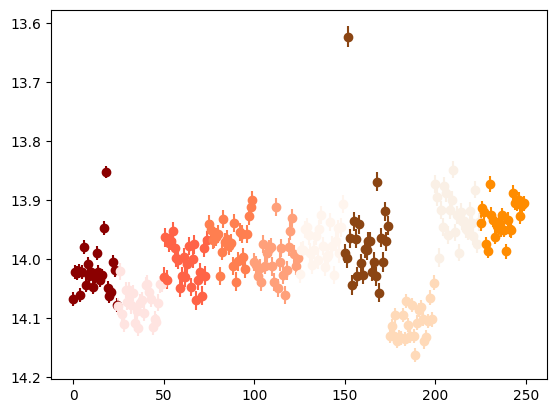

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01841136, 54.22552572)>, 'Source Radius: 6.5', 'Source Id: 50', 'Is Reference Star: None', 'Is Bad Source: None')


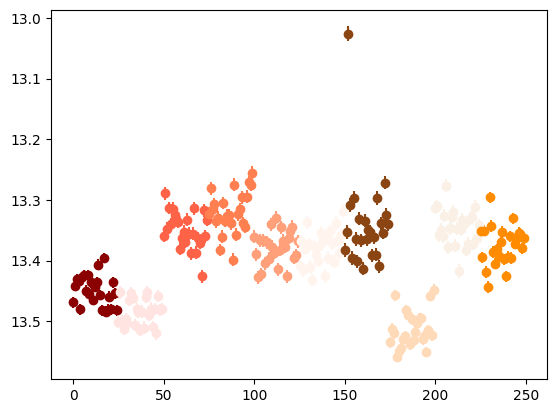

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.03006488, 54.35204566)>, 'Source Radius: 4.0', 'Source Id: 51', 'Is Reference Star: None', 'Is Bad Source: None')


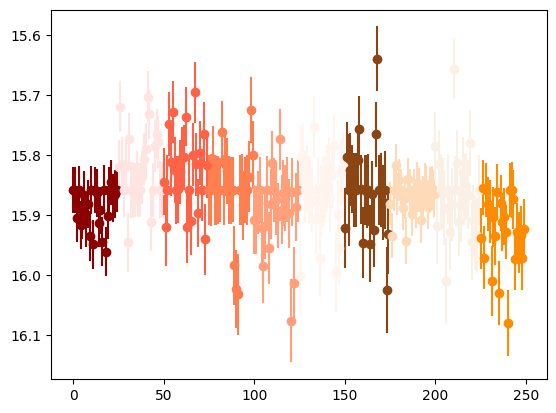

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.04682416, 54.42158107)>, 'Source Radius: 4.5', 'Source Id: 52', 'Is Reference Star: None', 'Is Bad Source: None')


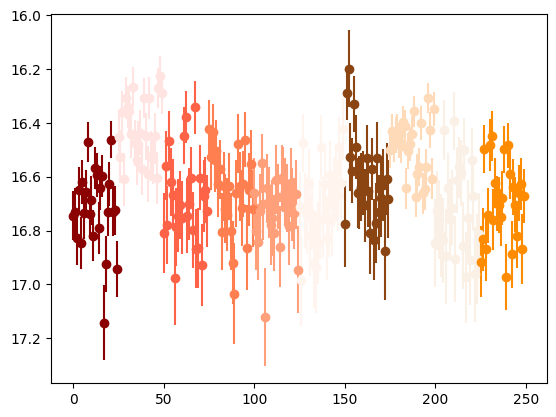

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.03188549, 54.00407838)>, 'Source Radius: 4.5', 'Source Id: 53', 'Is Reference Star: True', 'Is Bad Source: None')


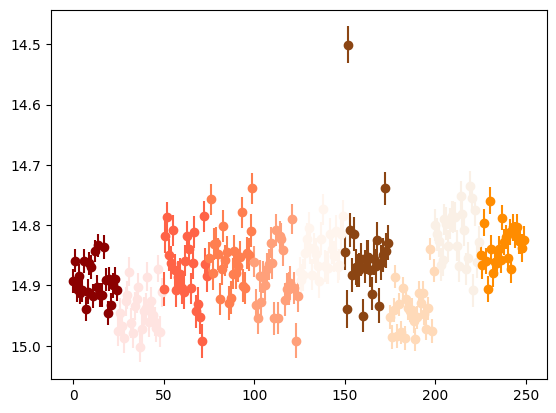

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.05144253, 54.23152052)>, 'Source Radius: 3.0', 'Source Id: 54', 'Is Reference Star: None', 'Is Bad Source: None')


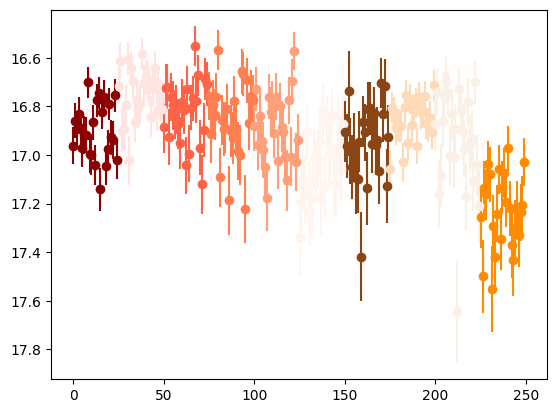

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.04809302, 53.9938326)>, 'Source Radius: 3.0', 'Source Id: 55', 'Is Reference Star: True', 'Is Bad Source: None')


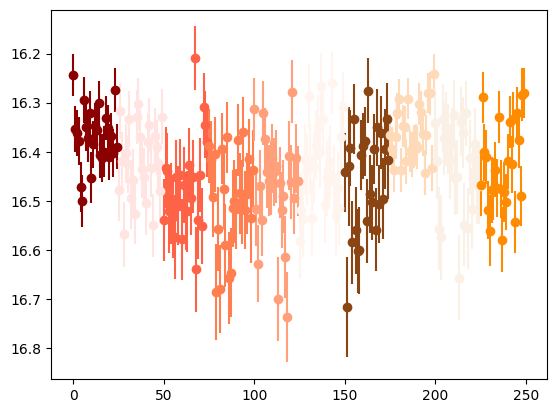

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.0674882, 54.42881879)>, 'Source Radius: 5.5', 'Source Id: 56', 'Is Reference Star: True', 'Is Bad Source: None')


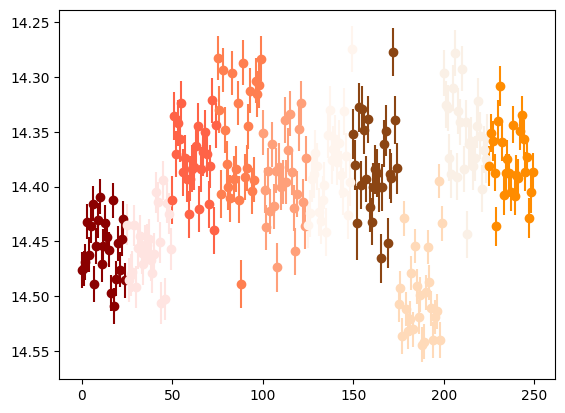

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.06828153, 54.39069706)>, 'Source Radius: 4.0', 'Source Id: 57', 'Is Reference Star: None', 'Is Bad Source: None')


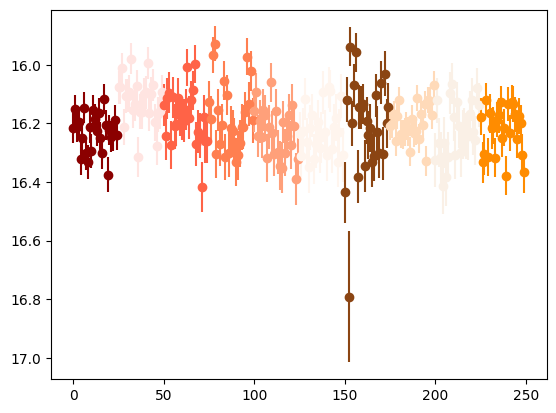

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.06442548, 54.00816578)>, 'Source Radius: 7.0', 'Source Id: 58', 'Is Reference Star: True', 'Is Bad Source: None')


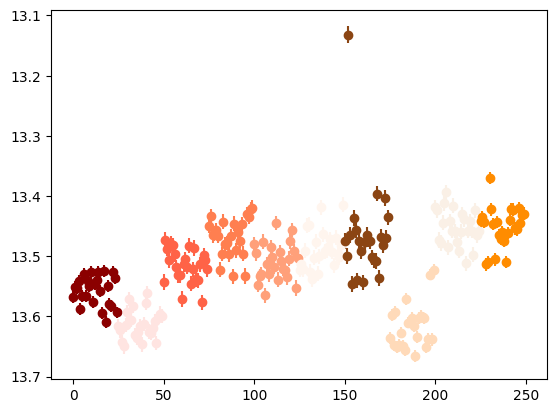

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.08497635, 54.39021174)>, 'Source Radius: 6.5', 'Source Id: 59', 'Is Reference Star: None', 'Is Bad Source: None')


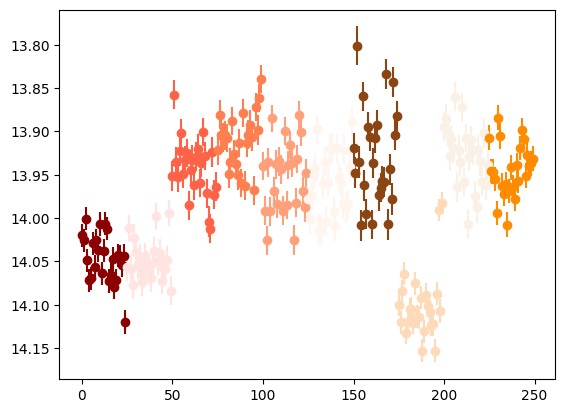

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.09030766, 54.32292807)>, 'Source Radius: 10.5', 'Source Id: 60', 'Is Reference Star: None', 'Is Bad Source: None')


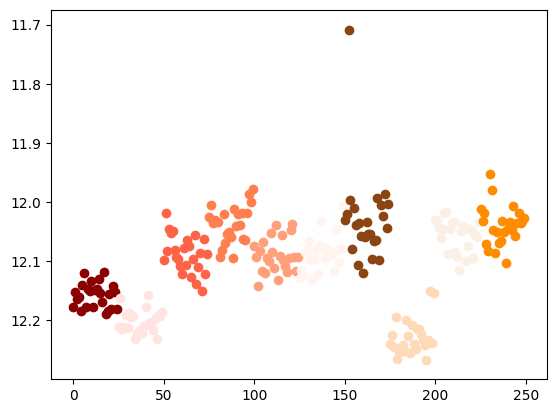

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12036051, 54.39700063)>, 'Source Radius: 7.5', 'Source Id: 61', 'Is Reference Star: None', 'Is Bad Source: None')


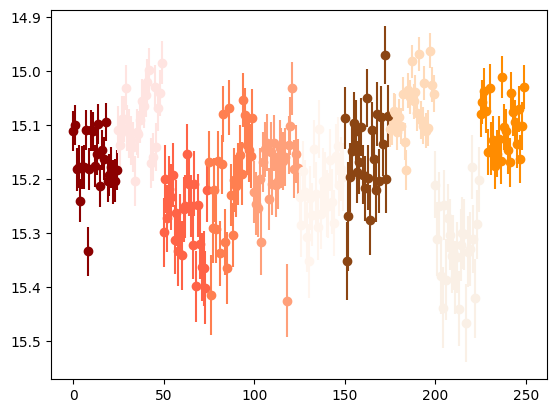

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12238072, 54.3964228)>, 'Source Radius: 9.5', 'Source Id: 62', 'Is Reference Star: None', 'Is Bad Source: None')


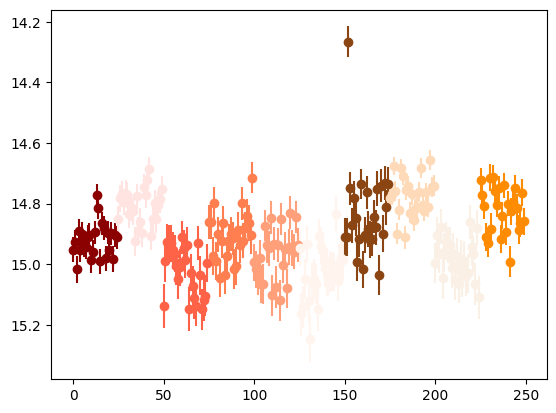

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12184327, 54.39801681)>, 'Source Radius: 5.5', 'Source Id: 63', 'Is Reference Star: None', 'Is Bad Source: None')


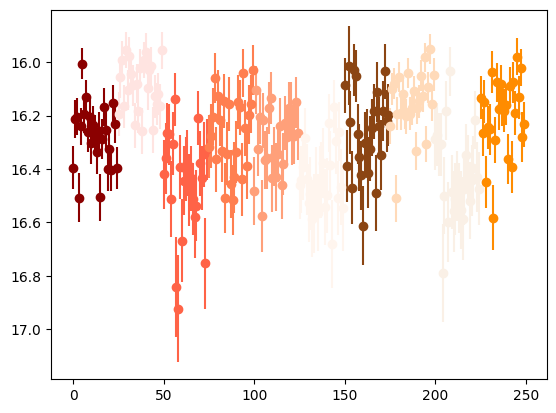

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12521481, 54.25972344)>, 'Source Radius: 3.0', 'Source Id: 64', 'Is Reference Star: None', 'Is Bad Source: None')


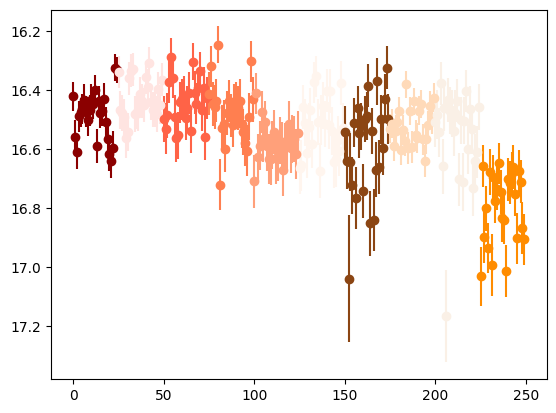

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12054456, 54.08428834)>, 'Source Radius: 5.0', 'Source Id: 65', 'Is Reference Star: True', 'Is Bad Source: None')


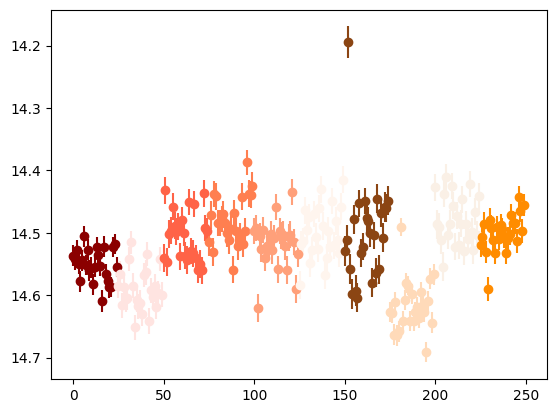

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.17529361, 54.35187118)>, 'Source Radius: 9.5', 'Source Id: 66', 'Is Reference Star: None', 'Is Bad Source: None')


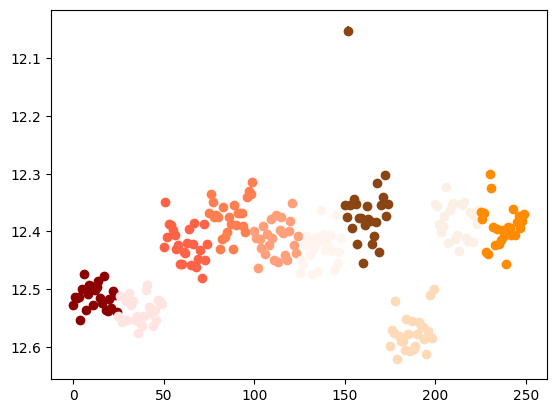

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.21211591, 54.19464639)>, 'Source Radius: 3.5', 'Source Id: 67', 'Is Reference Star: True', 'Is Bad Source: None')


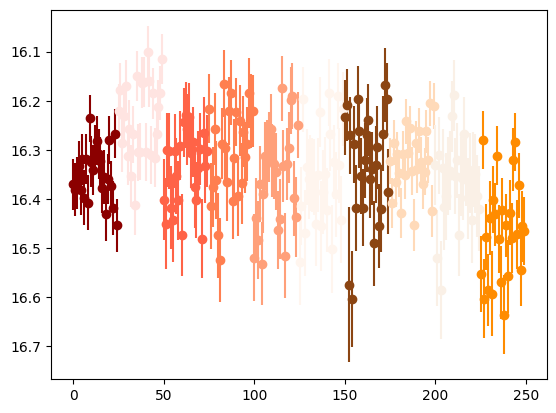

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.231828, 54.40298931)>, 'Source Radius: 5.0', 'Source Id: 68', 'Is Reference Star: True', 'Is Bad Source: None')


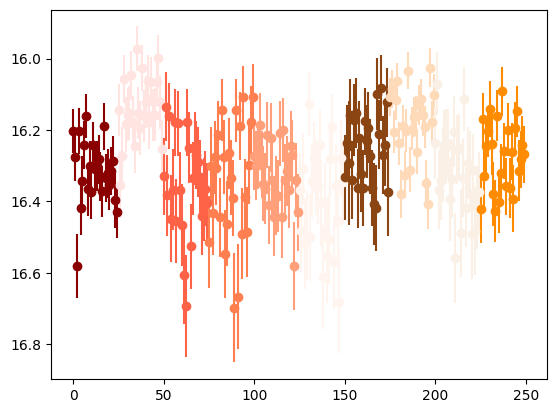

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.23332181, 54.22956903)>, 'Source Radius: 2.5', 'Source Id: 69', 'Is Reference Star: True', 'Is Bad Source: None')


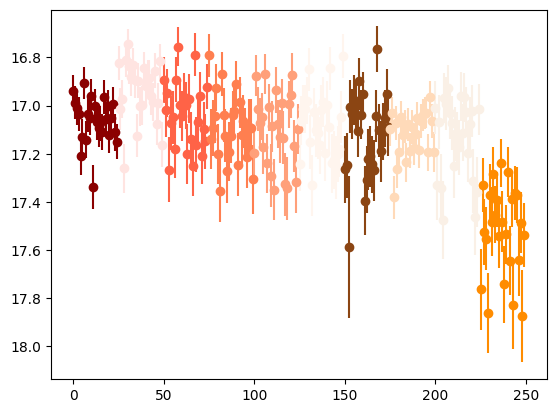

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.25972667, 54.33924396)>, 'Source Radius: 7.0', 'Source Id: 70', 'Is Reference Star: True', 'Is Bad Source: None')


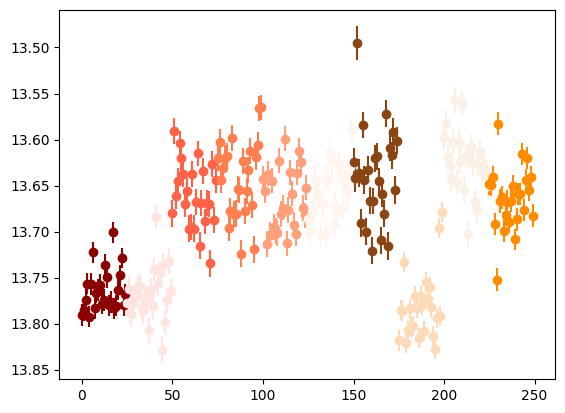

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.27877934, 54.05855765)>, 'Source Radius: 21.0', 'Source Id: 71', 'Is Reference Star: True', 'Is Bad Source: None')


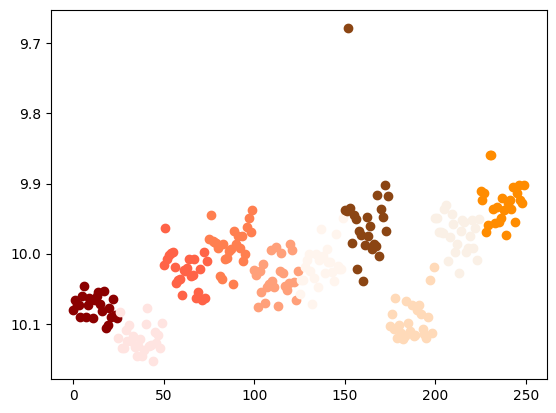

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30345384, 54.41397668)>, 'Source Radius: 3.0', 'Source Id: 72', 'Is Reference Star: True', 'Is Bad Source: None')


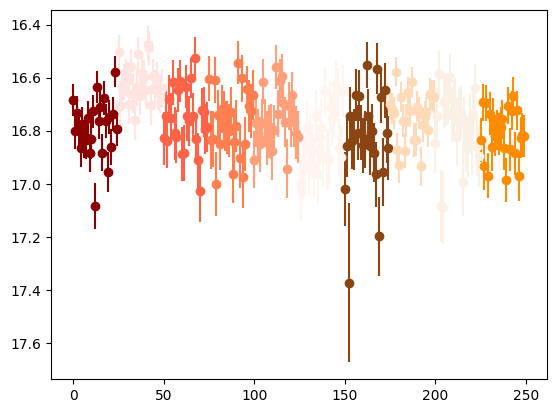

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.29844756, 54.26495767)>, 'Source Radius: 3.0', 'Source Id: 73', 'Is Reference Star: True', 'Is Bad Source: None')


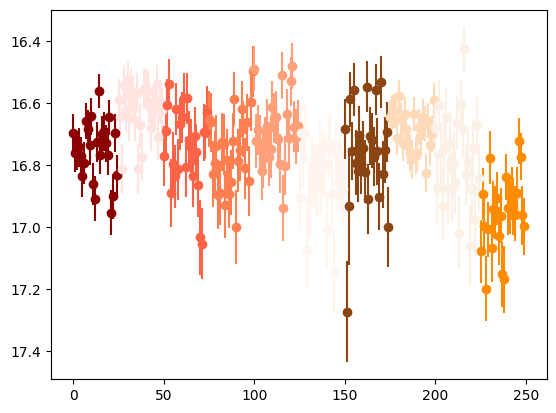

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30476211, 54.37648842)>, 'Source Radius: 3.5', 'Source Id: 74', 'Is Reference Star: True', 'Is Bad Source: None')


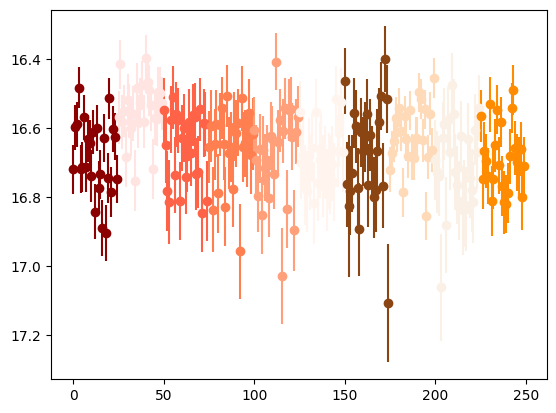

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30066365, 54.21154036)>, 'Source Radius: 5.0', 'Source Id: 75', 'Is Reference Star: True', 'Is Bad Source: None')


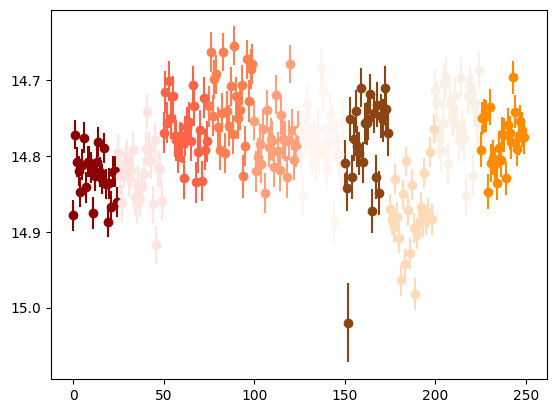

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.29289799, 53.99842441)>, 'Source Radius: 3.5', 'Source Id: 76', 'Is Reference Star: True', 'Is Bad Source: None')


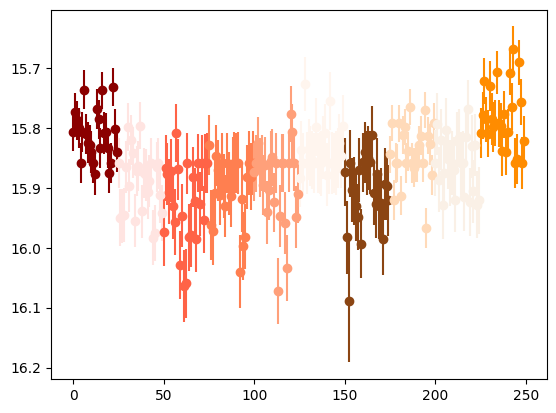

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30979078, 54.07608885)>, 'Source Radius: 3.0', 'Source Id: 77', 'Is Reference Star: True', 'Is Bad Source: True')


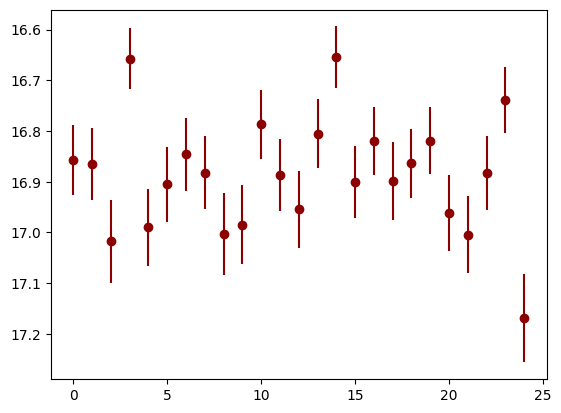

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.32647274, 54.42447666)>, 'Source Radius: 3.0', 'Source Id: 78', 'Is Reference Star: True', 'Is Bad Source: True')


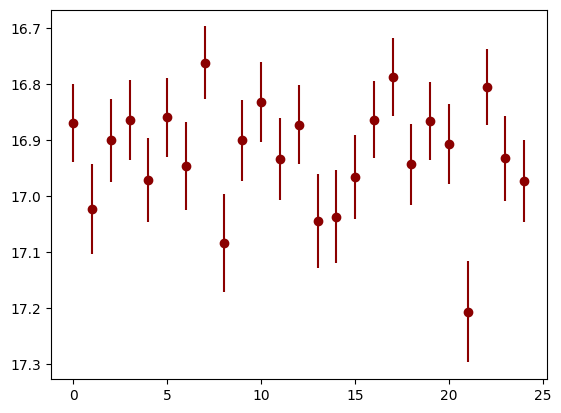

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.31921793, 54.17948362)>, 'Source Radius: 4.0', 'Source Id: 79', 'Is Reference Star: True', 'Is Bad Source: True')


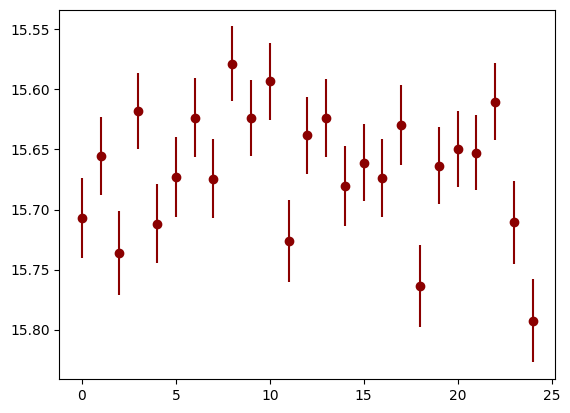

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.31467094, 54.01658955)>, 'Source Radius: 5.0', 'Source Id: 80', 'Is Reference Star: True', 'Is Bad Source: True')


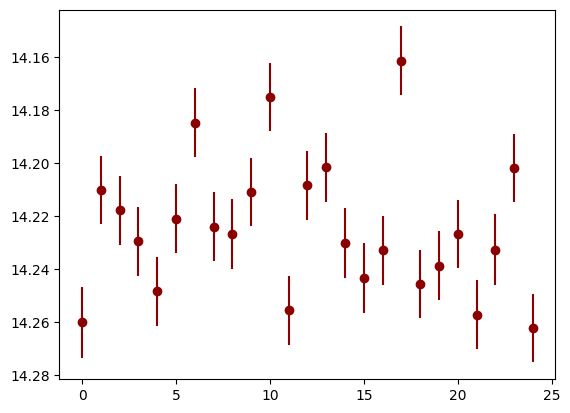

In [526]:
for source in sources:
    print(source.get_info())
    r = np.arange(0, len(source.calibrated_mags))
    for i, value in enumerate(source.calibrated_mags):
        plt.errorbar(i, value/med_curve[i], yerr=source.instrumental_mag_errs[i], linestyle = 'none', marker = 'o', c = color_arr[20::2][np.array(night_array)][i] )
    plt.gca().invert_yaxis()
    plt.show()


In [527]:
print(calibration_parameters)

[array([[ 0.97722377],
       [24.14631812]]), array([[ 0.9784492 ],
       [24.16323898]]), array([[ 0.97624909],
       [24.13945865]]), array([[ 0.97623847],
       [24.14161455]]), array([[ 0.97710437],
       [24.1505692 ]]), array([[ 0.97672876],
       [24.13605643]]), array([[ 0.97591801],
       [24.13533842]]), array([[ 0.9711272],
       [24.0791478]]), array([[ 0.9735496 ],
       [24.09754812]]), array([[ 0.97846502],
       [24.16655467]]), array([[ 0.97252037],
       [24.08419093]]), array([[ 0.97576249],
       [24.13385616]]), array([[ 0.9782633 ],
       [24.16182466]]), array([[ 0.97393253],
       [24.1116803 ]]), array([[ 0.97807298],
       [24.16266947]]), array([[ 0.97992381],
       [24.18329804]]), array([[ 0.97817999],
       [24.15800116]]), array([[ 0.97340172],
       [24.10672763]]), array([[ 0.97678372],
       [24.17448518]]), array([[ 0.97376188],
       [24.11332055]]), array([[ 0.97872612],
       [24.16774098]]), array([[ 0.97847667],
       [24.16

In [528]:
for night in Sets:
    print(night.obs_filter)

r
r
r
r
r
r
r
r
r
r
